In [1]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi
from pathlib import Path
from tqdm import tqdm
from typing import List

mi.set_variant('cuda_ad_rgb')

from mimt import *
set_siggraph_font()

In [2]:
def create_scene(integrator: str, resolution=(256, 256)):
    scene_dict = mi.cornell_box()

    scene_dict['sensor']['film']['width']  = resolution[1]
    scene_dict['sensor']['film']['height'] = resolution[0]

    scene_dict['integrator']['type']      = integrator
    scene_dict['integrator']['max_depth'] = 5 # limit moderate depth
    scene_dict['sensor']['film']['sample_border'] = True

    # Remove the boxes and add a custom shape
    del scene_dict['large-box']
    del scene_dict['small-box']
    scene_dict['shape'] = {
        'type': 'sphere',
        'radius': 0.5,
        'bsdf': {
            'type': 'roughplastic',
            'diffuse_reflectance': {
                'type': 'rgb',
                'value': [1, 0.6, 0.1]
            }
        }
    }

    return scene_dict

def apply_transform_sphere(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['shape.to_world'] = mi.Transform4f().translate([0, 0, -offset]) @ original
    params.update()
    return params

def apply_transform_mesh(params: mi.SceneParameters, original: Tuple[mi.Float, mi.Float], offset: float):
    vertex_positions_original = original[0]
    vertex_normals_original   = original[1]
    transform = mi.Transform4f().translate([0, 0, -offset])
    params['shape.vertex_positions'] = dr.ravel(transform.transform_affine(dr.unravel(mi.Point3f,  vertex_positions_original)))
    params['shape.vertex_normals']   = dr.ravel(transform.transform_affine(dr.unravel(mi.Vector3f, vertex_normals_original)))
    params.update()
    return params

In [3]:
def generate_data(integrators: List[str], spp: int, spp_grad: int):
    data = {}

    for shape in ['Sphere', 'Teapot']:
        # Generate the data for the gi
        data[shape] = []
        for integrator in (pbar:= tqdm(integrators, leave=False, desc="integrator")):
            tqdm.write("    "+integrator)
            pbar.set_postfix_str(integrator)
            scene_dict = create_scene(integrator=integrator.lower())
            if shape == 'Teapot':
                scene_dict['shape']['type'] = 'ply'
                del scene_dict['shape']['radius']
                scene_dict['shape']['filename'] = 'data/teapot.ply'
                scene_dict['shape']['to_world'] = mi.ScalarTransform4f().translate([0,-0.3,0]).rotate([0, 1, 0], -150).rotate([1, 0, 0], -110).scale(0.25)
            scene = mi.load_dict(scene_dict)

            params   = mi.traverse(scene)
            if shape == 'Sphere':
                original = mi.Transform4f(params['shape.to_world'])
                apply_transform = apply_transform_sphere
            else:
                original = (mi.Float(params['shape.vertex_positions']), mi.Float(params['shape.vertex_normals']))
                apply_transform = apply_transform_mesh

            # Render primal image
            img = mi.render(scene, params=params, seed=10, spp=spp, spp_grad=spp_grad)

            # Compute gradients
            render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
            grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.01)
            grad_fw = compute_gradient_forward(render_with_offset, 0.)
            
            data[shape].append((integrator, img, grad_fd, grad_fw))

    return data

In [4]:
integrators = ['prb_threepoint', 'prb_projective']
data = generate_data(integrators, spp=4*1024, spp_grad=4*1024)

integrator:   0%|          | 0/2 [00:00<?, ?it/s, prb_threepoint]

    prb_threepoint


integrator:  50%|█████     | 1/2 [00:02<00:02,  2.20s/it, prb_projective]

    prb_projective


integrator:   0%|          | 0/2 [00:00<?, ?it/s, prb_threepoint]        

    prb_threepoint


integrator:  50%|█████     | 1/2 [00:02<00:02,  2.11s/it, prb_projective]

    prb_projective


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5138738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5008872].


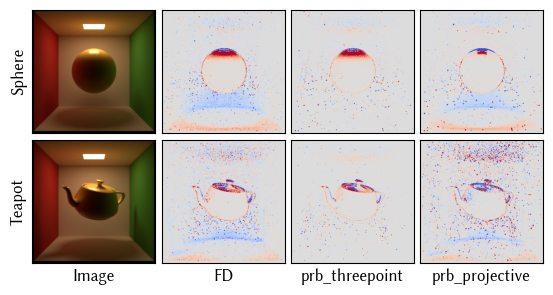

In [5]:
generate_figure(integrators, data, Path("output/case_3_forward.pdf"), grad_projection='mean', square_r_setting_3=False, quantile=0.99)

In [3]:
def generate_data_pose_estimation(integrators: List[str], num_iterations: int, spp_ref: int, spp_opt: int, spp_opt_grad: Optional[int] = None):
    num_runs = 6
    data = {}
    for run_index in range(num_runs):
        run_key = f'pose_{run_index}'
        data[run_key] = [] # .append((integrator, img, grad_fd, grad_fw))
        for integrator in integrators:
            scene_dict = create_scene(integrator, resolution=(128, 128))
            scene_dict['shape']['type'] = 'ply'
            del scene_dict['shape']['radius']
            scene_dict['shape']['filename'] = 'data/teapot.ply'
            scene_dict['shape']['to_world'] = mi.ScalarTransform4f().translate([0,-0.3,0]).rotate([0, 1, 0], -150).rotate([1, 0, 0], -110).scale(0.25)
            scene = mi.load_dict(scene_dict)
            params = mi.traverse(scene)

            vertex_positions_original = mi.Float(params['shape.vertex_positions'])
            vertex_normals_original   = mi.Float(params['shape.vertex_normals'])

            img_ref = mi.render(scene, spp=spp_ref)
            # mi.Bitmap(img_ref)

            rng = np.random.default_rng(run_index)

            opt = mi.ad.Adam(lr=1e-2)
            t = 0.25 # 0.2
            opt['offset'] = t*mi.Point3f(0.5*(2*rng.random(3)-1))
            opt['quat']   = (1-t)*mi.Quaternion4f(1) + t*mi.Quaternion4f(2*rng.random(4)-1)

            losses = []
            for it in range(num_iterations):
                q_opt = dr.normalize(opt['quat'])
                R_opt = dr.quat_to_matrix(q_opt)
                transform_opt = mi.Transform4f().translate(opt['offset']) @ mi.Transform4f(R_opt)

                params['shape.vertex_positions'] = dr.ravel(transform_opt.transform_affine(dr.unravel(mi.Point3f, vertex_positions_original)))
                params['shape.vertex_normals']   = dr.ravel(transform_opt.transform_affine(dr.unravel(mi.Vector3f, vertex_normals_original)))
                params.update()

                img_opt = mi.render(scene, params=params, spp=2*spp_opt, spp_grad=spp_opt, seed=it)

                loss = dr.mean(dr.abs(img_opt - img_ref))
                dr.backward(loss)
                opt.step()

                if it == 0:
                    with dr.suspend_grad():
                        img_init = mi.render(scene, spp=spp_ref, seed=it)

                dr.print(f"[{run_index+1}/{num_runs}, {integrator}] Iteration {it}, Loss {loss}", end='\r')
                losses.append(dr.detach(loss))

            # Re-render optimized image with reference spp
            with dr.suspend_grad():
                img_opt = mi.render(scene, spp=spp_ref, seed=it)

            dr.eval(img_ref, img_init, img_opt, *losses)
            del params, scene

            data[run_key].append((integrator, img_ref, img_init, img_opt, losses))
    return data

data_pose = generate_data_pose_estimation(integrators=['prb_threepoint', 'prb_projective'], num_iterations=200, spp_ref=128, spp_opt=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.191437e-12..3.509837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.256068e-10..3.50339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2559678e-10..3.5032535].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.2384265e-10..3.5124264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.256068e-10..3.5031428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.3505345e-10..3.4992645].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.2384265e-10..3.5091274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.256068e-10..3.5034494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2559676e-10..3.496687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.2384265e-10..3.496841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.256068e-10..3.504544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2559677e-10..3.499377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

0.008335626 0.022045938
0.008497637 0.022035733
0.008178516 0.024971038
0.016297435 0.02496314
0.008295317 0.017819643
0.013704321 0.019758556
0.0084891785 0.024095982
0.017591095 0.022868682
0.008268435 0.023474779
0.008484749 0.023439258
0.008275671 0.02291586
0.011287302 0.02290152


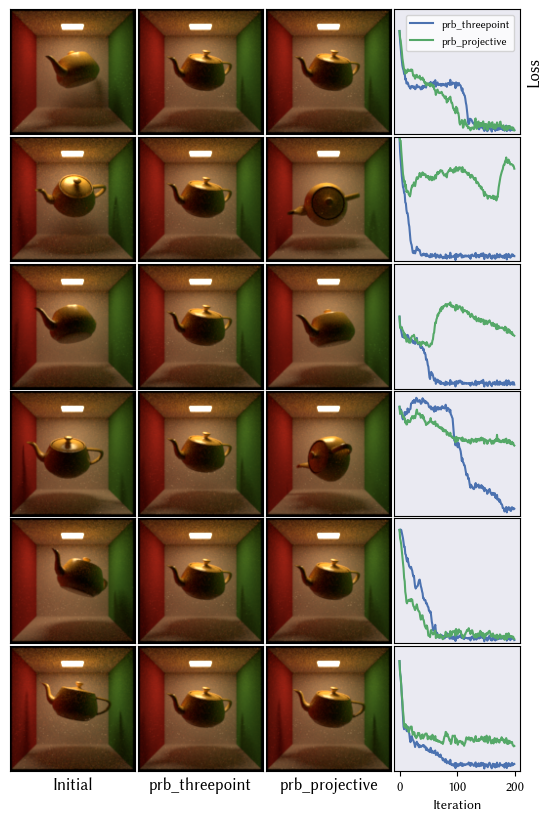

In [40]:
import matplotlib.patheffects as pe

plt.rc('axes', prop_cycle=plt.style.library['seaborn-v0_8']['axes.prop_cycle'])

num_integrators = len(list(data_pose.values())[0])

n_rows = len(list(data_pose.keys()))
n_cols = 1+num_integrators+1
aspect = n_rows/n_cols
fig = plt.figure(figsize=(FIGURE_WIDTH_ONE_COLUMN, aspect*FIGURE_WIDTH_ONE_COLUMN))

gs = fig.add_gridspec(n_rows, n_cols, wspace=0.015, hspace=0.02)

num_runs = n_rows
for run_idx, (_, run_data) in enumerate(data_pose.items()):
    img_ref = run_data[0][2]
    ax = disable_ticks(fig.add_subplot(gs[run_idx, 0]))
    ax.imshow(mi.Bitmap(img_ref).convert(srgb_gamma=True), extent=(0, 1, 0, 1))
    if run_idx == num_runs-1:
        ax.set_xlabel("Initial", fontsize=12)

    ax_loss = fig.add_subplot(gs[run_idx, -1])
    ax_loss.set_ylim(ymin=0.008, ymax=0.025)
    ax_loss.set_yticks([])
    ax_loss.yaxis.tick_right()
    ax_loss.yaxis.set_label_position("right")
    ax_loss.set_facecolor('#EAEAF2')
    if run_idx == 0:
        ax_loss.set_ylabel("Loss", fontsize=12)
    if run_idx != num_runs - 1:
        ax_loss.set_xticks([])
    else:
        ax_loss.set_xlabel("Iteration", fontsize=10)
    for integrator_idx, integrator_data in enumerate(run_data):
        img_opt = integrator_data[3]
        ax = disable_ticks(fig.add_subplot(gs[run_idx, 1 + integrator_idx]))
        ax.imshow(mi.Bitmap(img_opt).convert(srgb_gamma=True), extent=(0, 1, 0, 1))
        if run_idx == num_runs-1:
            ax.set_xlabel(integrator_data[0], fontsize=12)

        losses = [l.numpy() for l in integrator_data[4]]
        print(np.min(losses), np.max(losses))
        ax_loss.plot(losses, label=integrator_data[0])
    if run_idx == 0:
        ax_loss.legend(fontsize=8)

fig.savefig("output/case_3_pose.pdf", facecolor='white', bbox_inches='tight', dpi=300)